In [1]:
#import libraries:

import os
import seaborn as sns
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import numpy as np
from io import StringIO
import pydotplus

In [2]:
#use the csv sheets provided or fredapi library to get the data of economic factors:
#currently there are 11 features in the drive, you can add any other features which you feel are suitable in detecing the regimes:

csv_lst=list(os.walk('FredData'))[0][2]
itemList=[pd.read_csv('FredData/'+file_name,keep_default_na=True,na_values='.') for file_name in csv_lst]
itemList=itemList[:-7]+itemList[-4:] # delete the series that only contain data after 2003

In [3]:
#put them to a list, clear NA values
for i in range(len(itemList)):
    itemList[i]=itemList[i].dropna(axis=0,how='any') 
    itemList[i].columns=['Date', csv_lst[i][5:-4]]


In [4]:
#Preprocessing, use appropriate methods to fill the missing values in the data:
#upsample and interpolate to get the daily data 

sample=itemList[0]

def interpolateAsDaily(data):
    daily_data=data.set_index('Date').resample('D').mean().ffill()
    return daily_data

for i in range(len(itemList)):
    itemList[i]['Date']=pd.to_datetime(itemList[i]['Date'])
    itemList[i]=interpolateAsDaily(itemList[i]) 

# new_all.to_csv('./all.csv') 

In [5]:
#group all the data
new_all = itemList[0]
for i in itemList[1:]:
    new_all = pd.merge(new_all, i, on = 'Date')
    
new_all

,BASE,CIVPART,CP,CPIAUCSL,CPILFESL,DCOILWTICO,DFF,DGS10,DGS30,DGS5,...,PAYEMS,PCE,PCEDG,PSAVERT,RRSFS,STLFSI,T10YIE,T5YIE,T5YIFR,TCU
Date,,,,,,,,,,,,,,,,,,,,,
1995-01-05,-0.000246,0.001499,0.032004,0.002003,0.000632,0.011390,-0.132018,0.007673,0.007643,0.007682,...,0.002892,0.001983,-0.011257,0.041667,0.001675,0.014720,-0.001699,-0.111111,0.002366,-0.019661
1995-01-06,-0.000246,0.001499,0.032004,0.002003,0.000632,-0.003941,-0.034965,-0.001269,-0.005057,0.000000,...,0.002892,0.001983,-0.011257,0.041667,0.001675,0.084139,-0.001699,-0.027778,0.002366,-0.019661
1995-01-07,-0.000246,0.001499,0.032004,0.002003,0.000632,-0.003941,0.000000,-0.001269,-0.005057,0.000000,...,0.002892,0.001983,-0.011257,0.041667,0.001675,0.084139,-0.001699,-0.027778,0.002366,-0.019661
1995-01-08,-0.000246,0.001499,0.032004,0.002003,0.000632,-0.003941,0.000000,-0.001269,-0.005057,0.000000,...,0.002892,0.001983,-0.011257,0.041667,0.001675,0.084139,-0.001699,-0.027778,0.002366,-0.019661
1995-01-09,-0.000246,0.001499,0.032004,0.002003,0.000632,-0.016393,0.000000,0.002541,0.003812,0.003812,...,0.002892,0.001983,-0.011257,0.041667,0.001675,0.084139,-0.001699,-0.114286,0.002366,-0.019661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-14,0.003477,0.001582,0.020875,0.001877,0.001668,0.015715,0.000000,-0.042105,-0.025862,-0.040462,...,0.001319,0.001275,-0.004201,-0.026667,0.000182,0.013585,-0.003914,0.000000,0.000872,-0.008361
2019-12-15,0.003477,0.001582,0.020875,0.001877,0.001668,0.015715,0.000000,-0.042105,-0.025862,-0.040462,...,0.001319,0.001275,-0.004201,-0.026667,0.000182,0.013585,-0.003914,0.000000,0.000872,-0.008361
2019-12-16,0.003477,0.001582,0.020875,0.001877,0.001668,0.001664,0.006452,0.038462,0.017699,0.036145,...,0.001319,0.001275,-0.004201,-0.026667,0.000182,0.013585,-0.003914,0.000000,0.000872,-0.008361


In [6]:
#split the data

datasets = new_all.iloc[:, 1:]

#feature scaling
sc_X = StandardScaler()
X_Train = sc_X.fit_transform(datasets)

In [7]:
#conduct PCA analysis on the processed data:

n_pca=28
pca = PCA(n_components = n_pca)
newData = pca.fit_transform(X_Train)
print(f"The explained variance ratio of {n_pca} components is {sum(pca.explained_variance_ratio_):.2%}") 

The explained variance ratio of 28 components is 92.80%


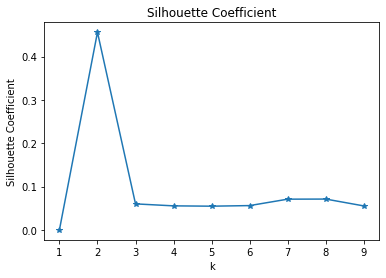

In [8]:
#additional task:once the PCA is conducted apply any clusterting techniques to find regimes:
# check the silhousette coefficient to choose the optimal k-

scores = [0]
for k in range(2, 10):
    estimator = KMeans(n_clusters=k)
    estimator.fit(newData)
    scores.append(silhouette_score(newData, estimator.labels_, metric='euclidean'))
x = range(1, 10)
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient')
plt.plot(x, scores, '*-')
plt.title('Silhouette Coefficient')
plt.show()

In [9]:
#fit a K-means model (K=2)

data1=new_all.reset_index()
datetime = data1['Date']

kmeans = KMeans(n_clusters =2)
kmeans.fit(newData)
classRes = pd.DataFrame(kmeans.fit_predict(newData))

res = kmeans.labels_
res_seri = pd.Series(res)
res_seri.index=new_all.index

trainData = pd.concat([pd.DataFrame(newData,index=new_all.index), res_seri], axis = 1)

columnlst=['PC'+str(i+1) for i in range(n_pca)]
columnlst.append('Cluster')

trainData.columns = columnlst
trainData.index=new_all.index

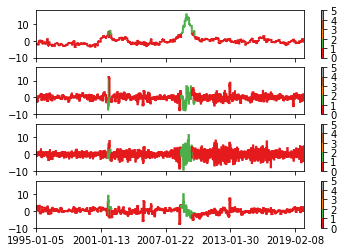

In [10]:
import matplotlib.ticker as mticker

fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)

cmap = plt.get_cmap('Set1')
norm = BoundaryNorm([0, 1, 2, 3, 4, 5], cmap.N)
x = np.array(range(trainData.shape[0]))
new_all=trainData
cluster = new_all['Cluster']
data1['Date']=pd.to_datetime(data1['Date']).dt.date
for i in range(4):
    
    y = new_all['PC'+str(i+1)]

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(cluster)
    lc.set_linewidth(2)
    line = axs[i].add_collection(lc)
    fig.colorbar(line, ax=axs[i])


xlabels = axs[0].get_xticks().tolist()
axs[0].xaxis.set_major_locator(mticker.FixedLocator(xlabels))
axs[0].xaxis.set_ticks(range(0,trainData.shape[0],2200))
axs[0].xaxis.set_ticklabels(data1['Date'][0:trainData.shape[0]:2200])
axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-10, 18)

plt.show()

In [11]:
#split the data into train and test:

x_train,x_test,y_train,y_test = train_test_split(trainData.iloc[:,:-1],trainData.iloc[:,-1],test_size=0.3,random_state=420)

In [12]:
#train the data using stats libraries by applying decision tree and find the accuracy on the test data:

dt=DecisionTreeClassifier(criterion='gini',max_depth=None,min_samples_leaf=100,ccp_alpha=0.02)
dt.fit(x_train,y_train)

train_pre = dt.predict(x_train)
test_pre = dt.predict(x_test)

train_error = np.mean((train_pre!=y_train))
test_error = np.mean((test_pre!=y_test))
print(f'The accuracy rate on testset of Decision tree is {1-test_error:.2%}')

feature_names = columnlst[:-1]
target_names = ['1', '2','3']
dot_data = StringIO()
tree.export_graphviz(dt,
                     out_file=dot_data,
                     feature_names=feature_names,
                     class_names=target_names,
                     filled=True, 
                     rounded=True,
                     special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("Decision_tree.pdf") # visualize the fitted decision tree

The accuracy rate on testset of Decision tree is 99.67%


True

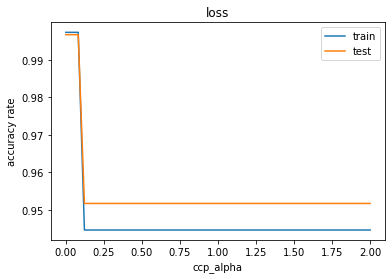

In [13]:
#Varies the parameter of decision tree

alpha=np.linspace(0,2,50)
def f(alpha):
    dt=DecisionTreeClassifier(criterion='gini',max_depth=None,min_samples_leaf=100,ccp_alpha=alpha)
    dt.fit(x_train,y_train)

    train_pre = dt.predict(x_train)
    test_pre = dt.predict(x_test)

    train_error = np.mean((train_pre!=y_train))
    test_error = np.mean((test_pre!=y_test))
    return train_error,test_error

train_error=[0]*50
test_error=[0]*50

for i in range(50):
    train_error[i],test_error[i]=f(alpha[i])
    train_error[i],test_error[i]=1-train_error[i],1-test_error[i]

    
plt.plot(alpha,train_error)
plt.plot(alpha,test_error)
    
plt.title("loss")
plt.xlabel("ccp_alpha")
plt.ylabel("accuracy rate")
plt.legend(['train', "test"], loc=0, ncol=1)
plt.show()

In [14]:
# Compare with other ML methods

estimator={"SVM":svm.SVC(kernel='rbf'),"Guassian NB":GaussianNB(),'LDA':LinearDiscriminantAnalysis(),"Random Forest":RandomForestClassifier()}

train_accuracy=dict()
test_accuracy=dict()
           
def f(method):
    md=estimator[method]

    md.fit(x_train,y_train)

    train_pre = md.predict(x_train)
    test_pre = md.predict(x_test)

    train_error = np.mean((train_pre!=y_train))
    test_error = np.mean((test_pre!=y_test))
           
    train_accuracy[method]=1-train_error
    test_accuracy[method]=1-test_error
           
for item in estimator.keys():
    f(item)

for item in estimator.keys():
    print(f'The accuracy rate on testset of {item} is {test_accuracy[item]:.2%}')

The accuracy rate on testset of SVM is 99.78%
The accuracy rate on testset of Guassian NB is 95.14%
The accuracy rate on testset of LDA is 100.00%
The accuracy rate on testset of Random Forest is 99.96%


### The scores of methods

| <div style="width:180px">ML method </div>| <div style="width:180px">Test accuracy</div>  |<div style="width:180px">Train accuracy</div> |
|:--------| :---------:|:---------:|
|Decision tree |99.67%|99.73%|
|SVM |  99.78%|  100.00%|
|Guassian NB |  95.14%|  95.06%|
|LDA |  100.00%|  99.98%|
|Random Forest |  99.96%|  100.00%|

